<div align="center">

# COSC2968 | COSC3053
## Foundations of Artificial Intelligence for STEM

# Assignment 3: Option A - Machine Learning

## Project: Weather Prediction Model for New York City

### Team 2

| Role | Name | Student ID |
|:-----|:-----|:-----------|
| Team Member | Nguyen Ngoc Dung | s3978535 |
| Team Member | Le Dam Quan | s4031504 |
| Team Member | Nguyen Tran Ha Phan | s3977970 |
| Team Member | Phan Tri Hung | s4001980 |
| Team Member | Tran Quoc Hung | s4045608 |

<br>
<div align="center">
Lecturer/Tutor: Hoang Tuan Anh
</div>

<div align="center">
Date: [8/9/2024]
</div>


</div>

---

## Introduction

This notebook demonstrates the implementation of a comprehensive Machine Learning pipeline to forecast future maximum temperatures in New York City using historical weather data. We evaluate and fine-tune multiple models to determine the best performer for this task.

The dataset used in this project comprises various weather-related features, including temperature, humidity, wind speed, cloud cover, and other meteorological variables.

Our approach involves the following steps:

1. Data loading and initial preprocessing
2. Exploratory Data Analysis (EDA) and visualization
3. Advanced feature engineering
4. Feature selection and correlation analysis
5. Implementation of diverse machine learning models
6. Model evaluation using K-Fold cross-validation
7. Fine-tuning of the best performing model
8. Final model evaluation
9. Generation of future predictions

## Table of Contents

1. [Data Loading and Initial Preprocessing](#data-loading-and-initial-preprocessing)
2. [Exploratory Data Analysis and Visualization](#exploratory-data-analysis-and-visualization)
   - [Correlation Heatmap](#correlation-heatmap)
   - [Feature Distributions](#feature-distributions)
   - [Feature Relationships with Max Temperature](#feature-relationships-with-max-temperature)
   - [Temperature Variable Distributions](#temperature-variable-distributions)
3. [Data Preparation and Feature Engineering](#data-preparation-and-feature-engineering)
   - [Time-based Features](#time-based-features)
   - [Lag Features and Rolling Averages](#lag-features-and-rolling-averages)
   - [Feature Selection and Correlation Analysis](#feature-selection-and-correlation-analysis)
4. [Model Training and Initial Evaluation](#model-implementation-and-evaluation)
   - [K-Fold Cross-validation](#k-fold-cross-validation)
   - [Residual Analysis](#residual-analysis)
5. [Model Fine-tuning](#model-fine-tuning)
6. [Final Model Evaluation and Testing](#final-model-evaluation)
7. [Future Predictions](#future-predictions)
8. [Conclusion and Further Recommendations](#final-conclusion)

#### Import Libraries and Functions

In [1]:
#Cell [0]

# Standard Libraries
import os  # For file system operations such as creating directories.
import warnings  # For controlling warning messages.
from datetime import timedelta  # For handling time-related operations.

# Third-party Libraries

# Joblib for saving/loading models
import joblib  # For serializing Python objects (like models).

# Numpy and Pandas for numerical and data manipulation
import numpy as np  # For numerical computations, especially with arrays.
import pandas as pd  # For data manipulation and dataframes.

# Seaborn and Matplotlib for visualizations
import seaborn as sns  # Advanced data visualization library based on matplotlib.
import matplotlib.pyplot as plt  # Basic plotting library.

# Scipy for statistical distributions (used in RandomizedSearchCV)
from scipy.stats import randint, uniform, loguniform  # For specifying parameter search distributions.

# Sklearn utilities and transformers
from sklearn.base import BaseEstimator, TransformerMixin  # Base classes for creating custom transformers/estimators.
from sklearn.compose import ColumnTransformer  # For applying different preprocessing pipelines to specific columns.
from sklearn.pipeline import Pipeline, make_pipeline  # For creating machine learning workflows.

# Sklearn preprocessors and imputers
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler  # For encoding, feature generation, and scaling.
from sklearn.impute import SimpleImputer  # For handling missing values in datasets.

# Sklearn model evaluation and hyperparameter tuning
from sklearn.model_selection import (KFold, RandomizedSearchCV, cross_val_predict, cross_val_score, train_test_split)  # For cross-validation, hyperparameter tuning, and splitting datasets.
from sklearn.metrics import mean_squared_error  # For evaluating model performance with error metrics like MSE.

# Sklearn models
from sklearn.linear_model import BayesianRidge, Ridge, LinearRegression, Lasso  # Linear models for regression tasks.
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  # Ensemble models for regression.
from sklearn.svm import SVR  # Support Vector Regression.
from sklearn.neural_network import MLPRegressor  # Neural network regressor model.

# XGBoost and LightGBM - Gradient Boosting models
from xgboost import XGBRegressor  # XGBoost regressor for gradient boosting.
from lightgbm import LGBMRegressor  # LightGBM regressor for fast gradient boosting.

# Warnings related to model convergence
from sklearn.exceptions import ConvergenceWarning  # To suppress warnings related to non-convergence.


#### Configurations

-----------------------------------------------------------------------

1. Warning Suppression:
   - We suppress certain warnings so that the output remains clean and only focuses on significant information.
   - The FutureWarnings are ignored because they usually inform about some future changes in the libraries that do not impact the functionality of the code as of now.
   - We suppress warnings related to setting values on DataFrame copies or convergence issues - these messages are just noise, serving little use in the output.

2. Directory Creation:
   - We create three folders, 'figures', 'models' and 'saved_objects'.
   - These folders give easy access to the various outputs of our project.
   - The `exist_ok=True` argument allows the script not raise an error when the folders exist.

3. KFold Configuration:
   - We want 5-fold to have quite a robust model evaluation.
   - Shuffling is True, which randomizes the data before splitting to reduce any potential bias from the ordering of data.
   - A fixed random state is provided to ensure reproducibility in the results obtained.

4. Model Storage and Loading:
   - The function `store_model_or_pipeline` saves trained models or pipelines into a folder called 'models'.
   -  If a name is not provided, it takes the class name of the object as its filename.
   - The `load_model_or_pipeline` function retrieves saved models or pipelines.
   - These functions make use of joblib for effective serialization and deserialization of Python objects.

This setup gives us an excellent backbone for our machine learning pipeline, where saving and retrieving models will be easy, our outputs will be organized, and our working environment will not get all cluttered up. The cross-validation configuration will help to give us realistic estimates of the performance of our models.

In [2]:
#Cell [1]

# Suppress warnings for cleaner output
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", message="A value is trying to be set on a copy of a DataFrame")
warnings.filterwarnings("ignore", message="No further splits with positive gain")
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Create directories for storing outputs
os.makedirs('figures', exist_ok=True)  # For storing plots and visualizations
os.makedirs('models', exist_ok=True)   # For saving trained models
os.makedirs('saved_objects', exist_ok=True)  # For miscellaneous saved objects

# Configure KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to save models and pipelines
def store_model_or_pipeline(obj, name=""):
    """Store a trained model or pipeline to the 'models' folder."""
    if name == "":
        name = type(obj).__name__
    joblib.dump(obj, f'models/{name}.pkl')
    print(f'{name} saved successfully.')

# Function to load saved models and pipelines
def load_model_or_pipeline(name):
    """Load a model or pipeline from the 'models' folder."""
    obj = joblib.load(f'models/{name}.pkl')
    print(f'{name} loaded successfully.')
    return obj

------------------------------------------------------------
<a id='data-loading-and-initial-preprocessing'></a>
### **1. Data Loading and Initial Preprocessing** 
Here, we load the dataset and perform initial preprocessing steps, such as handling missing values, removing outliers, and creating additional time-based features.
1. Loading the data: Data is read from a csv file and stored in the pandas DataFrame. 
Minor adjustments were also made before futher processing: 
- datetime column is changed to a string format
- unnecessary columns (columns that doesn't influence the label) were removed including: 'name', 'icon','stations' and 'description'
2. Handling missing values: At first, we count the missing values in the data using the sum() function, which will be used for later comparison, after the imputation. As for the imputation itself, we have 2 actions:
- If the data is categorical, missing values are replaced with the string 'Unknown'.
- If the data is numerical, the missing values are filled with the column's median. 
 We then will count the missing values again to verify all the missing values have been handled.
3. Removing outliers: To be able to remove outliers, we used the function remove_outliers() to remove data in a specified column.
To classify and remove outliers, we use the Interquartile Range method (IQR): 
- The IQR = 75th percentile (Q3) - 25th percentile (Q1)
- We have also defined lower and upper bounds with the factor = 1.5
- The outliers will be values that are either smaller than the lower bound or higher than the upper bound.

In [3]:
#Cell [2]

# Load the data and perform initial cleaning
raw_data = pd.read_csv('datasets/NewYork.csv')
raw_data['datetime'] = pd.to_datetime(raw_data['datetime'])
raw_data.drop(columns=["name", "icon", "stations", "description"], inplace=True)

# Check for missing values before imputation
print("\nMissing values before imputation:")
print(raw_data.isnull().sum())

# Define function to remove outliers using IQR method
def remove_outliers(df, column, factor=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from 'tempmax' column
raw_data = remove_outliers(raw_data, 'tempmax')
print("\nShape of data after removing outliers:", raw_data.shape)

# Impute missing values
for column in raw_data.columns:
    if raw_data[column].dtype == 'object':
        raw_data[column].fillna('Unknown', inplace=True)  # For categorical columns
    else:
        raw_data[column].fillna(raw_data[column].median(), inplace=True)  # For numerical columns

# Check for missing values after imputation
print("\nMissing values after imputation:")
print(raw_data.isnull().sum())


Missing values before imputation:
datetime              0
tempmax               0
tempmin               0
temp                  0
feelslikemax          0
feelslikemin          0
feelslike             0
dew                   0
humidity              0
precip                0
precipprob            0
precipcover           0
preciptype          386
snow                  0
snowdepth             0
windgust              0
windspeed             0
winddir               0
sealevelpressure      0
cloudcover            0
visibility            0
solarradiation        0
solarenergy           0
uvindex               0
severerisk           40
sunrise               0
sunset                0
moonphase             0
conditions            0
dtype: int64

Shape of data after removing outliers: (1000, 29)

Missing values after imputation:
datetime            0
tempmax             0
tempmin             0
temp                0
feelslikemax        0
feelslikemin        0
feelslike           0
dew              

<a id='exploratory-data-analysis-and-visualization'></a>
### **2. Exploratory Data Analysis and Visualization**
In this section, we explore the dataset through various visualizations. We analyze the distributions of the numeric features and their correlations with the target variable (`tempmax`).

In [4]:
#Cell [3]

print('\n____________ Dataset info ____________')
print(raw_data.info())              
print('\n____________ Some first data examples ____________')
print(raw_data.head(3)) 
print('\n____________ Statistics of numeric features ____________')
print(raw_data.describe())    


____________ Dataset info ____________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          1000 non-null   datetime64[ns]
 1   tempmax           1000 non-null   float64       
 2   tempmin           1000 non-null   float64       
 3   temp              1000 non-null   float64       
 4   feelslikemax      1000 non-null   float64       
 5   feelslikemin      1000 non-null   float64       
 6   feelslike         1000 non-null   float64       
 7   dew               1000 non-null   float64       
 8   humidity          1000 non-null   float64       
 9   precip            1000 non-null   float64       
 10  precipprob        1000 non-null   int64         
 11  precipcover       1000 non-null   float64       
 12  preciptype        1000 non-null   object        
 13  snow              1000 non-null   float

### Correlation Heatmap

In this section, we analyze the correlations between numeric features in our dataset. Understanding these correlations is crucial for:

1. . Identifying strongly related features that may provide redundant information.
2. Detection of a possible problem of multi-collinearity which can be influential for the performance of our model.
3. Gaining insight into what variables might be most predictive of our target variable.

For this, we'll plot the relationships in a heatmap of our correlation matrix. That way, it is much easier to visualize any patterns because the color coding shows the strength and direction of any correlations.

<Figure size 1200x1000 with 0 Axes>

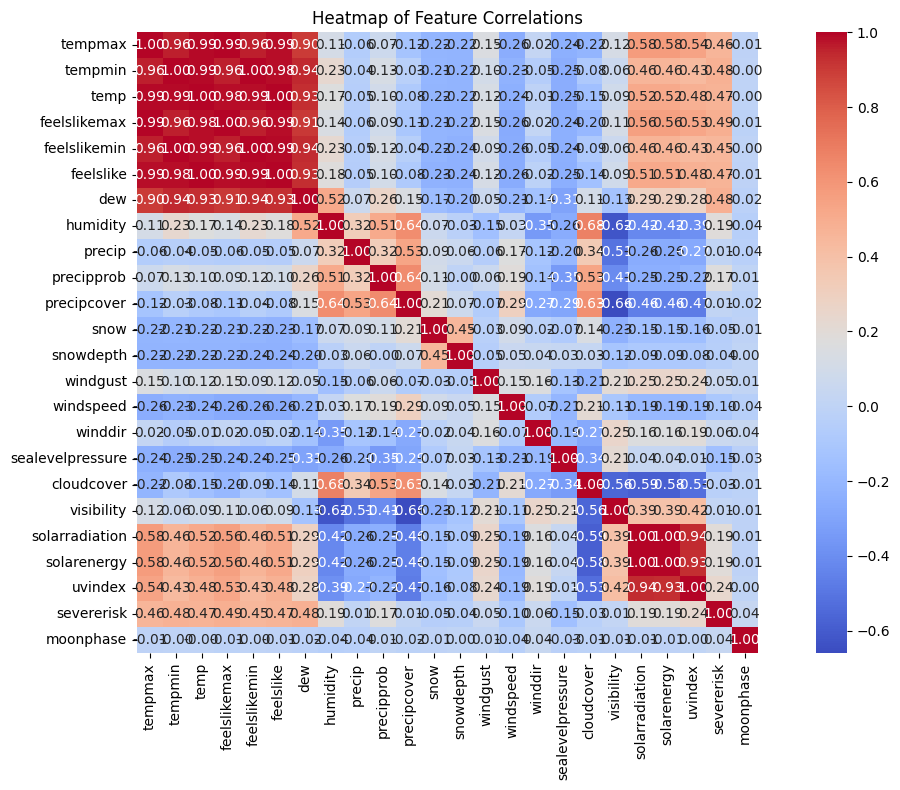

In [5]:
#Cell [3.1]

# Create correlation matrix for numeric features
plt.figure(figsize=(12, 10))
numeric_data = raw_data.select_dtypes(include=[np.number])
corr = numeric_data.corr()

# Handle any non-finite values in the correlation matrix
if not np.isfinite(corr.values).all():
    print("Warning: Correlation matrix contains non-finite values. Replacing with 0.")
    corr_array = np.nan_to_num(corr.values, nan=0, posinf=0, neginf=0)
    corr = pd.DataFrame(corr_array, index=corr.index, columns=corr.columns)

# Create and display heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Heatmap of Feature Correlations')
plt.tight_layout()

# Save the heatmap as a high-resolution image
plt.savefig('figures/correlation_heatmap.png', format='png', dpi=300)

# Display the plot
plt.show()

#### Heatmap of Feature Correlations: Analysis and Explanation

The heatmap visualizing correlations of different features of this dataset. The color legend represents different correlation coefficient values that range between -1 and 1, including:

- Red colors representing high positive correlations (close to 1)
- Blue colors representing high negative correlations (close to -1)
- Neutral colors (white/gray) representing weak or no correlation (close to 0)

#### Key Observations

##### Strong Correlations Between Temperature-Related Variables

- Features tempmax, tempmin, temp, feelslikemax, feelslikemin, and feelslike are highly correlated with each other. For most of them, their relationship is close to 1, showing that there is a very strong positive relationship among these variables.
- For instance:
  - tempmax is more than 0.99 for the following: tempmin, temp, feelslikemax
  - feelslike mirrors this trend, in that this actually is the temperature in several different forms: feels-like max and min.
- This is to be expected, since these variables are different measures of temperature, yet are fundamentally related, eg max temperature on a given day will dictate the feels-like max temperature.

##### Dew Point Correlation

- Dew is positively correlated with the temperature variables with values in the region of 0.90-0.95. This intuitively makes sense as dew is a function of humidity and temperature. A high dew usually implies it is warm and humid.

##### Humidity's Relationship

- It is moderately positively correlated with dew (~0.74) and more weakly with temperature variables (~0.12-~0.14). While humidity obviously has an impact on how hot or cold a certain temperature feels to people, its independent relationship with temperatures themselves is less than that of other features such as dew point.

##### Wind-Related Features

- Wind gust and wind speed are only weakly correlated with temperature-related features, with most values falling below 0.20.
- Windspeed is moderately negative correlated (~-0.25) with temperature. This negative correlation makes intuitive sense; strong winds are generally cold.
- Windgust is low but positively correlated (~0.15) with tempmax and temp.

##### Solar-Related Features

- These are solarenergy, solarradiation and uvindex. All of these features are moderately correlated (~0.54-0.58) with both tempmax and tempmin. Again, this intuitively makes sense: the stronger the solar radiation, UV index, and solar energy during the day, the hot it is likely to be.
- However, the said features have weaker correlations with dew and humidity.

##### Sealevel Pressure

- Sealevelpressure has weak negative correlations (~-0.23 to -0.25) with most of the temperature variables. The reason is that lower sea-level pressure usually accompanies stormy or cooler weather conditions.

##### Precipitation Variables

- Precip, Precipprob, and Precipcover are all very weakly, almost zero, correlated with the temperature variables, best 0.07. This would suggest that precipitation, whether in the form of rain or snow, is not a strong determinant of the variation in temperature in this dataset, though it may affect the overall feel of weather.
- Snowdepth has a somewhat stronger negative correlation (~-0.22) with temperature variables, which intuitively makes sense, since the accumulation of snow occurs under colder conditions.

##### Cloud Cover and Visibility

- Cloudcover has an approximate correlation of ~ - 0.23 on temperature variables. Generally speaking, increased cloudcover leads to lower amounts of solar radiation and lower temperatures.
- On the whole, visibility generally co-varies positively (~0.12) with temperature features, and one could make an educated guess that clearer days may be generally associated with higher temperatures.

##### Severe Risk

- High risk, might signal extreme weather, is at a moderate positive relation (~0.46) with tempmax. This would suggest that days with more extreme weather conditions have higher temperatures.
 
##### Moonphase

- As intuitively expected, moonphase is overall uncorrelated with any temperature-related or other weather variable because the phase of the moon has little implication for the day-to-day variation in weather conditions.

#### Discussion of Insights

1. **Highly Interdependent Temperature Variables**: As many of the temperature-related variables are very highly correlated, there would be redundancy in using all these features in any predictive model. A few of these could probably be excluded or combined to reduce multicollinearity without any loss in model accuracy.

2. **Dew and Humidity**: Most striking is how closely dew and temperature variables are in correspondence. The dew point could be a critical feature in predicting temperature because it captures how much moisture there is within the atmosphere and helps to explain how hot or cold it can feel.

3. **Wind and Solar Effects**: The solar-related features are moderately positively correlated with temperature, while the wind speed is very slightly negatively so. This would hint that winds are generally associated with cooler conditions, while high magnitudes of solar radiation are associated with the warmer days.

4. **Precipitation**: Curiously, the precipitation-probability, coverage, or actual amount-doesn't strongly correlate with any of the temperature features. This may indicate that most of the scenarios in the dataset include rain or snow regardless of the temperature range.

5. **Pressure**: Generally, lower sea-level pressure accompanies stormy or cooler conditions; therefore, it's negatively correlated to temperature features.

--------------------------------------------------------------
### Feature Distributions

Understanding the distribution of our numeric features is important for a few reasons, such as:

1. It'll show if the numeric feature is biased or has some interesting patterns.
2. Informed decisions will be able to be made on what type of preprocessing to perform-normalization or standardization.
3. It could also help in applying feature transformation to increase the performance of the model's performance.


In this section, we'll build the histograms of all the numeric features in our data. And each of these will be supported with a Kernel Density Estimate (KDE) line that provides a smooth view of the distribution. By this, we will have a very good idea of how our data is distributed across various features.


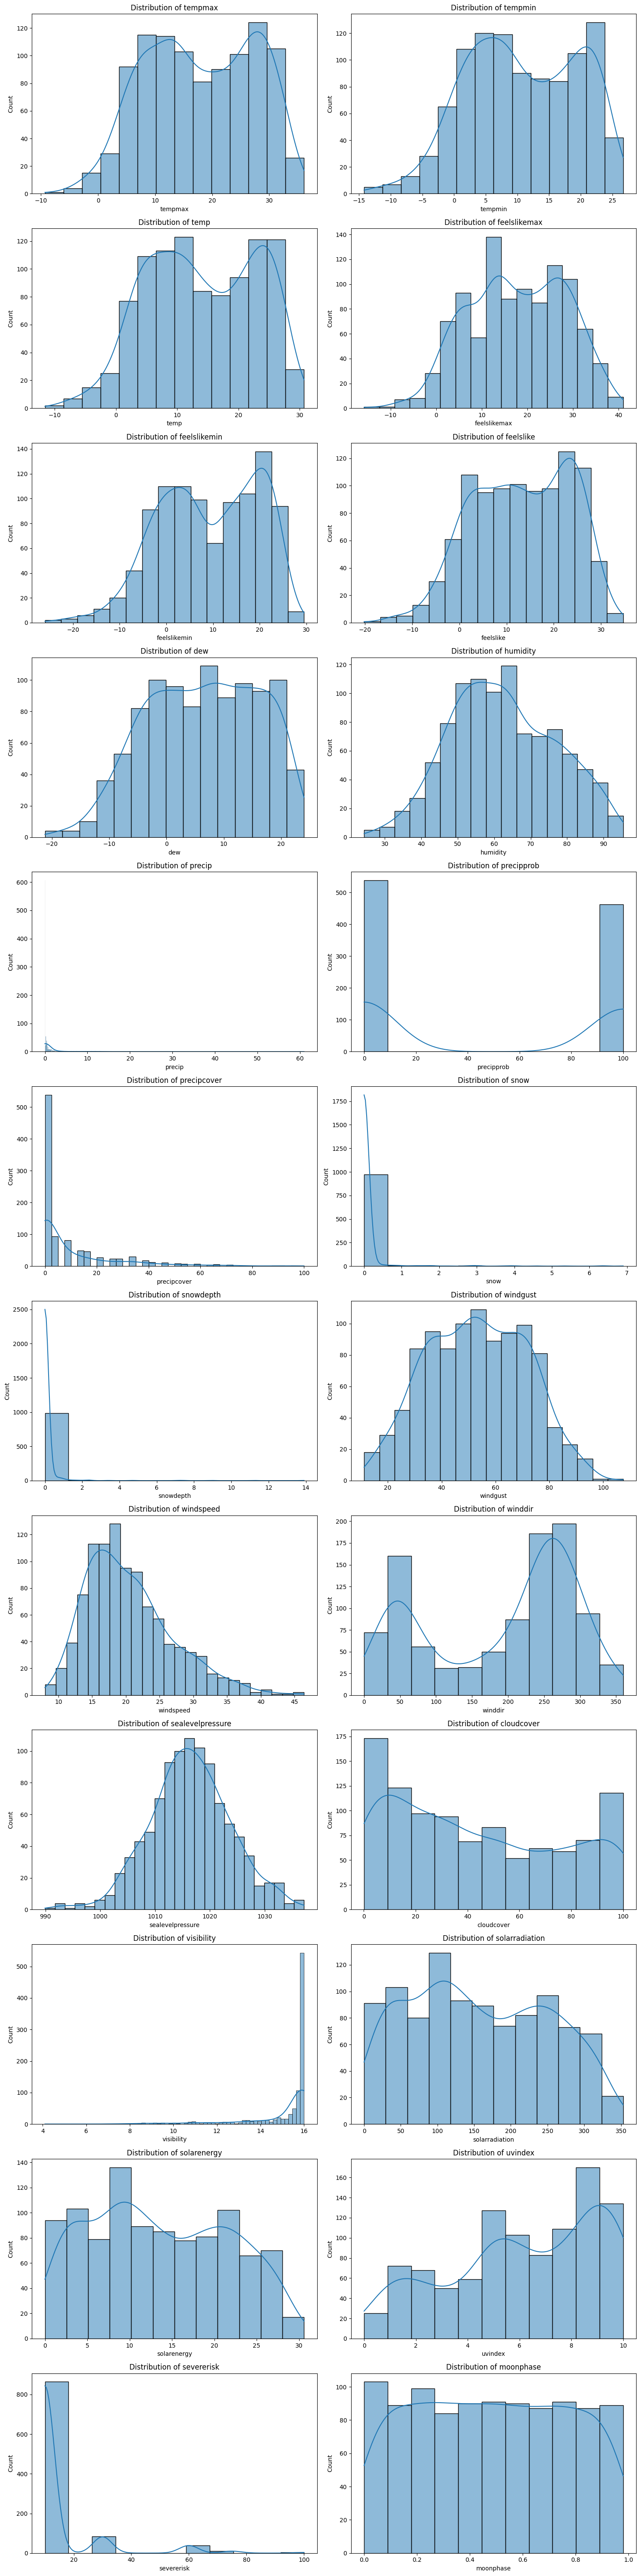

In [6]:
#Cell [3.2]

# Select numeric features from the dataset
numeric_features = raw_data.select_dtypes(include=[np.number]).columns
n_features = len(numeric_features)

# Calculate the number of rows needed for the subplot grid
n_rows = (n_features + 1) // 2

# Create a large figure to accommodate all histograms
plt.figure(figsize=(15, 5 * n_rows))

# Create a histogram for each numeric feature
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(n_rows, 2, i)
    sns.histplot(raw_data[feature], kde=True)
    plt.title(f'Distribution of {feature}')

# Adjust the layout and save the figure
plt.tight_layout()
plt.savefig('figures/hist_raw_data.png', format='png', dpi=300)

# Display the plot
plt.show()

#### Analysis of Histograms: Distribution of Variables

The following histograms represent the distribution of some of the weather-related variables of this dataset. Such graphs provide valuable insight into the underlying distribution, frequency, and dispersion of data.

#### Temperature-Related Variables

##### Tempmax (Maximum Temperature)

* Distribution: It is a bimodal distribution with peaks around 10°C and 30° C. Most of the values lie in the range between -10°C and 40°C.
* Insight: Very diverse range of temperature; might reflect winter and summer temperatures.

Tempmin (Minimum Temperature)
- Distribution: Bimodal with equal peaks like tempmax, between -10°C and 30°C.
- Insight: The range is highly variable for minimum temperatures; similar to that of max temperatures only it is shifted down a little.

##### Temp (Average Temperature)
- Distribution: Bimodal, peaking at around 10°C and another peak at around 25°C
- Insight: It captures most of the variation in temperature with a more evenly spread range of variation.

##### Feelslikemax (Feels Like Maximum Temperature)
- Distribution: Also follows the distribution of tempmax but slightly wider.
- Insight: The apparent "feels like" temperature tends to be broader because other factors such as wind and humidity already come into play.

##### Feelslikemin (Feels Like Minimum Temperature)
- Distribution: The distribution would be similar to that of tempmin but with extreme values being spread out.
- Insight: It means a larger variation in "feels like" temperature than what the actual minimum temperature indicates.

##### Feelslike (Feels Like Average Temperature)
- Distribution: Bimodal, with range similar to temp but higher variability.
- Insight: In perceived temperature, the distribution shows real temperature but with wider deviations.

#### Dew and Humidity Variables

##### Dew
- Distribution: Mainly uniform within a range of -10°C to 25°C.
- Insight: This series in dew point is relatively evenly distributed without any sharp peaks, hence it reflects a consistent variation between observations.

##### Humidity
- Distribution: Bimodal with peaks at approximately 40% and 80%.
Insight - The humidity is concentrated in two ranges: mid to low and higher values for humidity.

#### Precipitation Variables

##### Precip (Precipitation)
Distribution: Highly-skewed; most values are concentrated at zero.
Insight: Most of the observations have no precipitation. Sometimes extreme values record up to 50mm.

##### Precipprob (Precipitation Probability)
Distribution: U-shaped; high count for both 0% and 100%.
- Insight: This would suggest that there is some sort of binary-like behavior in the probability of precipitation; it is either highly likely or highly unlikely to rain.
##### Precipcover
- Distribution: Highly-skewed, most values falling below 20% .
- Insight: Most of the precipitation events cover a small portion of the area; rarely would it be highly covered.
#### Snow Variables
##### Snow
- Distribution: The distribution is highly-skewed - the vast majority of values are zero.
- Insight: Events of snowfall are few and mostly zero in the dataset, indicating low frequency of snow.

##### Snowdepth
- Distribution: Like snow, it is also mostly zero.
- Insight: In this area, accumulation of snow is seldom but it can be as high as up to 20cm when there is an event.

##### Wind and Visibility Variables

##### Windgust
- Distribution: Closer to being normally distributed, between 40km/hr to 120km/hr.
- Insight: Wind gusts are normally distributed with some higher gusts.

##### Windspeed
- Distribution: Right-skewed, most values are between 10 km/h and 30 km/h
- Insight: On average, normal wind speeds are low with some stray outliers.

##### Winddir (Wind Direction)
- Distribution: Bimodal, around 100° and 300°.
- Insight: There seems to be a preferred alignment of the wind direction around these two ranges, which might be induced by the prevailing wind patterns.

##### Visibility
- Distribution: It is highly skewed towards the maximum possible value, as most of the observations have clear visibility, approximately 16 km.
- Insight: On most days, the visibility is good, and hardly any instances are returned with poor visibility.

#### Solar and Radiation Variables

##### Solarradiation
- Distribution: In a uniform distribution within the range from 0 to 300 W/m².
- Insight: Solar radiation has an even distribution throughout the data, representing the variation in daylight conditions.

##### Solarenergy
- Distribution: Same as solarradiation, but a bit more crowded below 20 kWh/m².
- Insight: There were quite a lot of days with average solar energy. Fewer very intense days with solar energy.

##### Uvindex
- Distribution: Bimodal; peaks around 1 and around 8.
- Insight: UV index greatly varies; many very low and very high days.

Pressure and Cloud Cover Variables

##### Sealevelpressure
Distribution: Normal, centered at around 1010 hPa.
Insight: The sea-level pressure is normally distributed with small variation.

##### Cloudcover
Distribution: bimodal, with peaks around both 0% and 100%
Insight: Days have either very high or very low cloud cover with relatively few with partial cloud cover.

Severe Risk and Moonphase Variables

##### Severerisk
Distribution: highly positively skewed, most values close to zero.
- insight: Low severe weather risk for most of the observations.

##### Moonphase
- Distribution: Fairly even distribution of various phases of the moon.
- Insight: The phases of the moon are well-distributed as would be expected in the data.

#### Key Insights

1. Temperature Variables: All bimodally distributed with two apparent patterns or, said better, seasons likely Summer and Winter.
2. Precipitation and Snow: Values are mostly zero, reflecting that most days are dry, with few recorded instances of significant precipitation or snow.

3. Wind and Visibility: Wind speed was usually low to moderate, while visibility was very high for most of the period, which is indicative of good weather for most of the period.

4. Solar Radiation and Energy: Evenly distributed, which would suggest consistency in the daily variation of daylight.
5. Severe Risk: Very rarely does extreme weather appear in the dataset, and moon phases occur with equal frequency.

-----------------------------------------------------------------
### Feature Relationships with Max Temperature

Understanding how our target variable (maximum temperature) relates to other numeric features is crucial for our predictive modeling task. This analysis helps us:

1. Identify potential predictors that are strongly related to maximum temperature.
2. Detect the presence of non-linear relationships that might require special handling in our model.
3. Spot outliers or unusual patterns that could affect our predictions.

Below, we generate the scatter plots of maximum temperature against each of the other numeric features. From these plots we can visually infer the nature and strength of relationships between our target variable and potential predictors.

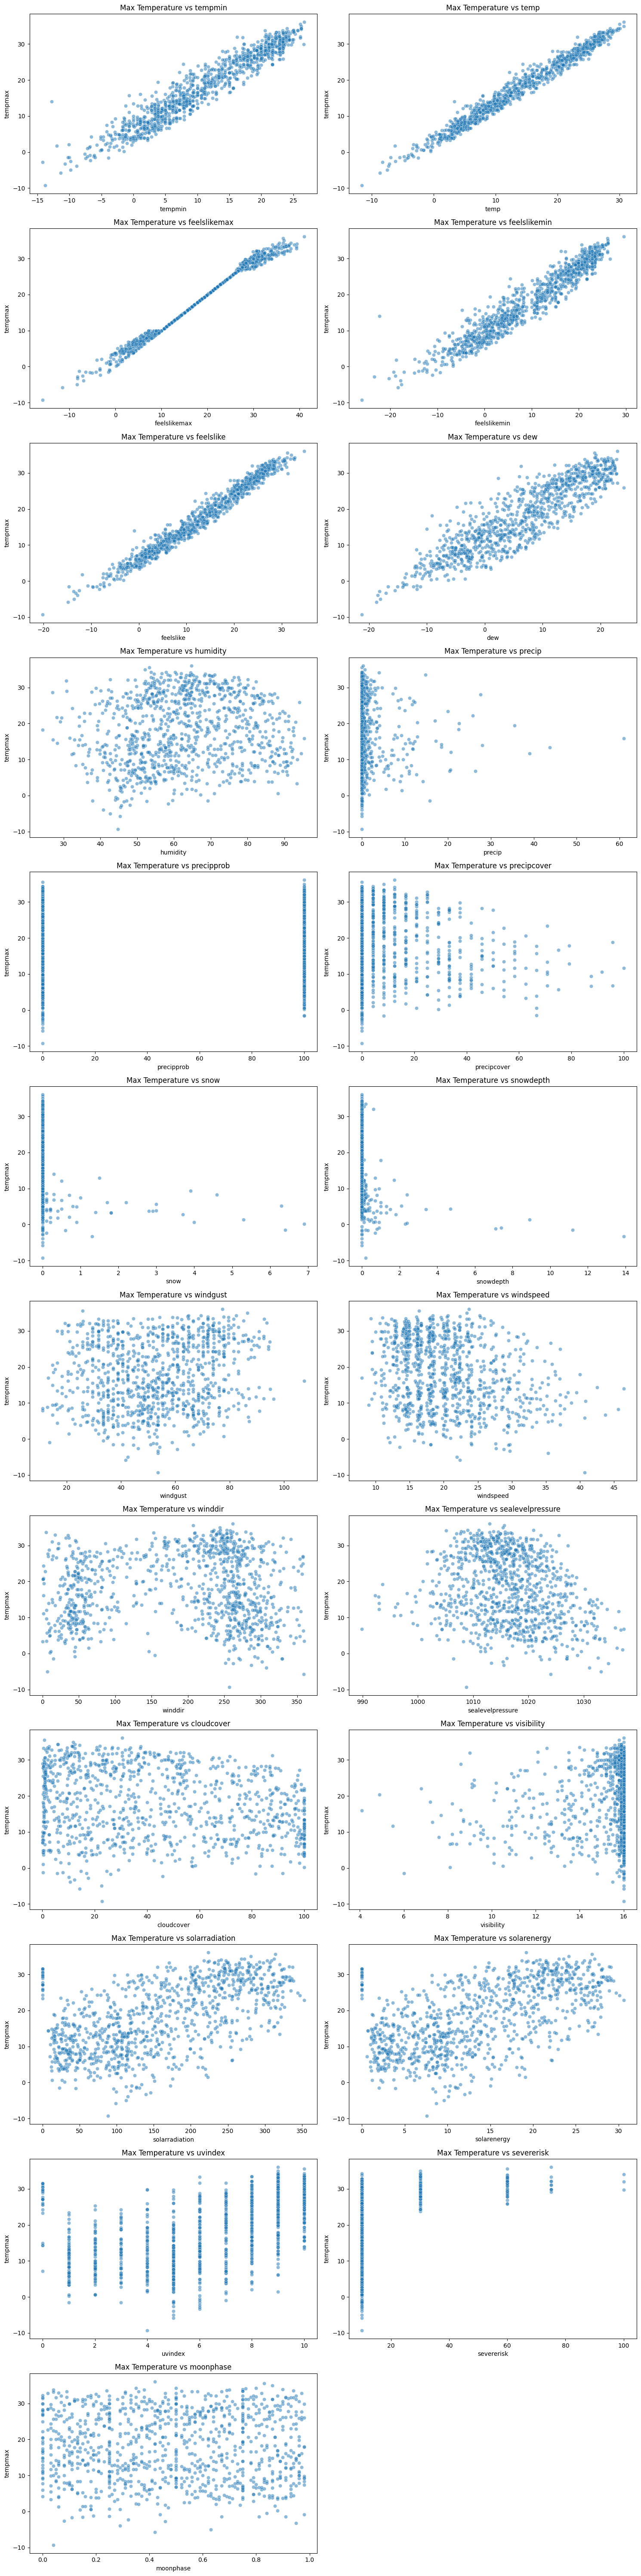

In [7]:
#Cell [3.3]

# Select all numeric features except 'tempmax'
numeric_features = [col for col in numeric_features if col != 'tempmax']
n_features = len(numeric_features)

# Calculate the number of rows needed for the subplot grid
n_rows = (n_features + 1) // 2

# Create a large figure to accommodate all scatter plots
plt.figure(figsize=(15, 5 * n_rows))

# Create a scatter plot for each feature vs tempmax
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(n_rows, 2, i)
    sns.scatterplot(data=raw_data, x=feature, y='tempmax', alpha=0.5)
    plt.title(f'Max Temperature vs {feature}')

# Adjust the layout and save the figure
plt.tight_layout()
plt.savefig('figures/scatter_tempmax_vs_features.png', format='png', dpi=300)

# Display the plot
plt.show()

#### Scatter Plot Analysis: Max Temperature vs Various Weather Features

These scatter plots show the trends of Maximum Temperature versus several other weather features. Each plot is different from all the others in terms of patterns, strengths of correlations, and even outliers.

#### Strongly Correlated Variables

##### Max Temperature vs Tempmin (Minimum Temperature)
- Insight: Strong positive linear relationship. As the minimum temperature increases, so does the maximum temperature. This would be expected as both are related by the daily overall shifts in temperature.
- Correlation: Almost perfect positive correlation.

##### Max Temperature vs Temp (Average Temperature)
- Insight: Very strong positive linear relationship. Average temperature is very well correlated with the maximum temperature.
- Correlation: Almost perfect correlation (similar to tempmin).

##### Max Temperature vs Feelslikemax (Feels Like Maximum Temperature)
- Insight: Another very strong positive relationship because the perceived temperature of maximum temperature would run almost parallel with the real temperature.
- Correlation: Almost perfect correlation. The tendency in this pattern shows that the actual maximum temperature corresponds strongly to the perceived maximum temperature.

##### Max Temperature vs Feelslikemin (Feels Like Minimum Temperature)
- Insight: Strong positive linear relationship. The perceived minimum temperatures are highly associated with the maximum temperature; however, it is weaker in strength compared to max feels-like values.
- Correlation: Positive-strong relationship. This actually means that there is a strong consistency between what people feel when outside regarding temperature and the actual temperature extremes.

##### Max Temperature vs Dew (Dew Point)
- Insight: Strong positive correlation, similar to temperature and dew point. As temperature increases, so does dew point. The dew points are typically higher when it is warmer outside.
- Correlation: Strong positive, though weaker than the temperature-related variables.

#### Weak or Non-Linear Correlations

##### Max Temperature vs Humidity
- Insight: There is no obvious relationship between max temp and humidity. This would tend to indicate that temperature doesn't vary strongly with humidity in a linear matter.
- Correlation: Very low or no correlation.

##### Max Temperature vs Precip (Precipitation)
- Insight:  Few data points and there is no clear pattern. Most of the values of precipitation are near zero, which means most days are dry whatever the temperature is.
- Correlation: Very low or no correlation since most of the points have zero precipitation.

##### Max Temperature vs Precipprob (Precipitation Probability)
- Insight: Data points are crowded at 0% and 100%, and hence, no underlying pattern between the range of temperature and probability of precipitation can be gauged from that.
- Correlation: No apparent correlation because the nature of the distribution of data is binary-like.

##### Max Temperature vs Precipcover (Precipitation Coverage)
- Insight: Distribution shows randomness; hence, it is difficult to comment on the relation between temperature and precipitation coverage area.
- Correlation: Very less or no correlation.

##### Max Temperature vs Snow
- Insight: All the points rest near zero since snow is a very rare occurrence, especially in high temperatures.
- Correlation: Very little or no correlation.

##### Max Temperature vs Snowdepth
- Insight: Similar to snow, most of the readings are around zero and hence show no variation of the depth of snow regarding temperature.
- Correlation: There is no significant correlation.

##### Max Temperature vs Windgust
- Insight: Light positive slope; higher the temperature, higher the wind gusts, but the relationship is not that strong.
- Correlation: weak to moderate positive correlation.

##### Max Temperature vs Windspeed
- Insight: No relation found; the wind speed hardly varies w.r.t. maximum temperature.
- Correlation: Very weak correlation.

##### Max Temperature vs Winddir (Wind Direction)
- Insight: There is random scatter and no apparent trend. No influence of direction of wind appears to affect the temperature.
- Correlation: No correlation.

##### Max Temperature vs Sealevelpressure
- Insight: A very weak negative correlation may mean higher temperatures could relate with low sea level pressure but very weak
- Correlation: Very weak negative correlation

##### Max Temperature vs Cloudcover
- Insight: Absolutely no good pattern is observed. A very minor, if at all, a trend could be the cloud cover decreases slightly with rise in temperature.
- Correlation: Very weak negative correlation.
- 
##### Max Temperature vs Visibility
- Insight: There is no relation that suggests any relationship between temperature and visibility. Most of the values of visibility are in a higher range close to maximum.
- Correlation: Very weak or no correlation.

#### Solar and Environmental Variables

##### Max Temperature vs Solarradiation (Solar Radiation)
- Insight: From the plot, it can be observed that temperature and solar radiation are moderately positively correlated, meaning days with higher temperatures experience higher solar radiation.
- Correlation: The scatter-plot indicates a moderate positive correlation.

##### Max Temperature vs Solarenergy
- Insight: Similar to solar radiation, days with higher temperature tend to enjoy higher amounts of solar energy.
- Correlation: The scatter-plot is moderately positive.

##### Max Temperature vs Uvindex
- Insight: From this scatter-plot, it is indicated that higher temperatures most times occur with a high UV index.
- Correlation: The scatter-plot is moderately positively correlated.

##### Max Temperature vs Severerisk
- Insight: No direct linkage of temperature to the risk of severe weather. Most of the values are around zero.
- Correlation: No good correlation.

##### Max Temperature vs Moonphase
- Insight: No trend visible. Moon phase values are scattered in a random manner regarding temperature.
- Correlation: No correlation.

#### Key Insights

1. Temperature Variables: The variables of minimum temperature, average temperature, and feels-like temperatures are highly correlated with maximum temperature. As expected, these show strong linear relationships.

2. Variance from the Weakly Correlated Variables: It seems that precipitation, wind speed, and cloud cover do not strongly correlate with maximum temperature, indicating perhaps that these factors do not influence temperature in a direct linear way.

3. Solar and UV Influence: Solar radiation and UV index are moderately correlated with maximum temperature. This makes natural intuitive sense in that the more solar energy, the higher the temperature.

4. Noisy and Sparse Data: Precipitation, snow, and severe risk variables have sparse or clustered data in a manner such that it's challenging to obtain any meaningful relationship to temperature.

---------------------------------------------------------------
### Temperature Variable Distributions

The distribution nature of temperature-related variables is a crucial aspect of our weather prediction model. This will help us in the following ways:

1. Compare ranges and central tendencies of various temperature measurements.
2. Establish possible outliers in temperature data.
3. Understand how actual temperatures relate to "feels like" temperatures.

In this section, we create a boxplot for six key temperature-related variables:
- `temp`: Average temperature
- `feelslike`: Average "feels like" temperature
- `tempmax`: Maximum temperature
- `feelslikemax`: Maximum "feels like" temperature
- `tempmin`: Minimum temperature
- `feelslikemin`: Minimum "feels like" temperature

Boxplots provide a compact summarization of the distribution. It shows for each of the variables the median and quartiles and possible outliers.

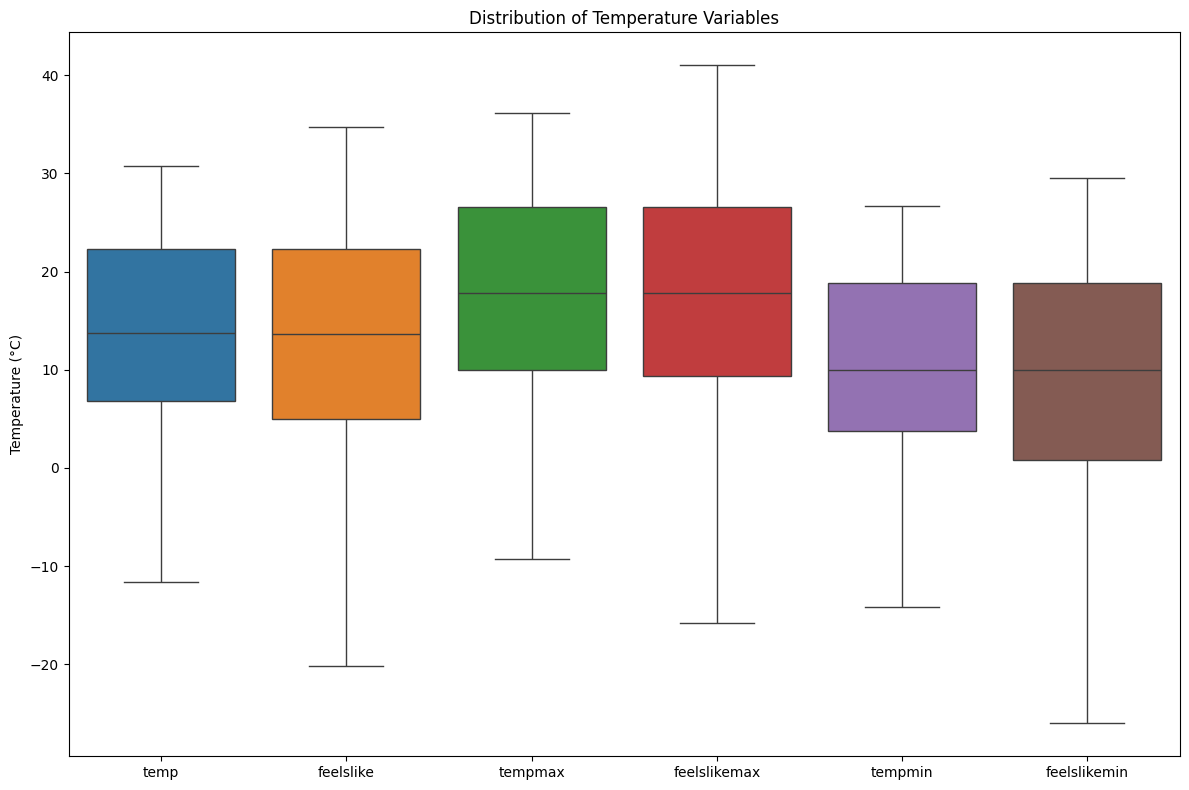

In [8]:
#Cell [3.4]

# Select the temperature-related features for plotting
temp_features = ['temp', 'feelslike', 'tempmax', 'feelslikemax', 'tempmin', 'feelslikemin']

# Create the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=raw_data[temp_features])

# Set titles and labels for the plot
plt.title('Distribution of Temperature Variables')
plt.ylabel('Temperature (°C)')
plt.xticks(ticks=range(len(temp_features)), labels=temp_features)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('figures/boxplot_temp_distributions.png', format='png', dpi=300)

# Display the plot
plt.show()

#### Boxplot Analysis: Distribution of Temperature Variables

This boxplot shows the distribution of six temperature-related variables, namely: Temp, which is the average temperature; Feelslike, which is perceived temperature; maximum temperature, Feelslike Max, which is perceived maximum temperature; minimum temperature; and Feelslike Min, which is perceived minimum temperature.

#### Key Insights

##### Temp (Average Temperature)
- Median: Around 15°C
- IQR: Ranges from about 7°C to 23°C
- Range: Approximately -10°C to 30°C
- Note: No extreme outliers; this means that a range of temperatures is constantly maintained.

##### Feelslike (Perceived Temperature)
- Median: Around 15°C, would be the actual temperature
- IQR: From 5°C up to 22°C, slightly narrower than in the actual temperature
- Range: The lowest values just below -10°C
- Note: Same pattern as actual temperature. An estimate of how hot it "feels" taking humidity, wind, and other conditions into account

##### Temp Max (Maximum Temperature)
- Median: About 20°C
- IQR: From 10°C to 30°C
- Range: Up to 35°C, with minimums close to -5°C
- Note: Significant dispersion in this data set.

##### Feelslike Max (Perceived Maximum Temperature)
- Median: Around 20°C (as for actual max)
- IQR: Slightly narrower compared to actual max
- Range: Almost equal to actual maximum, except for few outliers.
- Note: Perception less variable than actual temperature

##### Temp Min (Minimum Temperature)
- Median: Around 5°C
- IQR: Ranges from -5°C to 15°C
- Range: Can fall below -10°C but does not exceed 20°C
- Note: Accordingly, temperatures are seen to drop drastically during the night time

##### Feelslike Min (Perceived Minimum Temperature)
- Median: Close to 5°C (aligning well with actual minimum)
- IQR: Ranges from -7°C to 15°C
- Range: Few cases, apparent minimum falls greatly lower than the actual minimum
- Note: Probably because wind or humidity will make it feel that cold

#### Overall Analysis

1. Generally, the feels-like temperatures track the actual temperatures but divert a little due to environmental influence.

2. Maximum temperatures tend to be more variable, having a higher range compared to minimum temperatures, which fall around their medians.

3. Maximum temperatures tend to be more variable, having a higher range compared to minimum temperatures, which fall around their medians.

4. As expected, there is consistency in the trends of these temperature variables: actual and perceived temperatures are related, as are the averages, maximums, and minimums of the temperatures.

5. This boxplot will serve as another good method of viewing the range and distribution in these temperature variables and give insight into the climate patterns this dataset represents.

-----------------------------------------------------------------
<a id='data-preparation-and-feature-engineering'></a>
### **3. Data Preparation and Feature Engineering**
This section outlines some major enhancements to our dataset feature engineering and preparing a robust preprocessing pipeline. This will be of pivotal importance to enhance the performance of our model and structuring our data into a format apt for machine learning algorithms.

Some critical steps employed here include:

1. **Time-based Feature Engineering**: New features are generated from the datetime column to catch temporal patterns.
2. **Lag Features and Rolling Averages**: These features will help us capture time-dependent patterns and trends in our temperature data.
3. **Feature Selection**: We'll be selecting the features based on their correlation with our target variable, which is maximum temperature.
4. **Preprocessing Pipeline**: Create a pipeline to preprocess numeric and categorical features for modeling, including imputation and scaling.

This is the comprehensive approach that, beside feature engineering, embraces preprocessing and thus allows us to get most out of our data in an optimal way for our predictive models.

In [9]:
#Cell [4]
class EnhancedFeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_features=True):
        self.add_features = add_features
    
    def fit(self, X, y=None):
        return self
    
    ## Time-based Features
    def transform(self, X):
        X_ = X.copy()
        if isinstance(X_, pd.DataFrame) and self.add_features and 'datetime' in X_.columns:
            # Add new features from datetime
            X_['day_of_year'] = X_['datetime'].dt.dayofyear
            X_['month'] = X_['datetime'].dt.month
            X_['day_of_week'] = X_['datetime'].dt.dayofweek
            X_['is_weekend'] = X_['day_of_week'].isin([5, 6]).astype(int)
            X_['day_of_year_sin'] = np.sin(2 * np.pi * X_['day_of_year'] / 365.25)
            X_['day_of_year_cos'] = np.cos(2 * np.pi * X_['day_of_year'] / 365.25)
            X_.drop(columns=['datetime'], inplace=True)
        return X_
    
    
    
### Lag Features and Rolling Averages
# Function to add lag features
def add_lag_features(df, column, lags):
    for lag in lags:
        df[f'{column}_lag_{lag}'] = df[column].shift(lag)
    return df

# Function to add rolling averages
def add_rolling_features(df, column, windows):
    for window in windows:
        df[f'{column}_rolling_{window}'] = df[column].rolling(window).mean()
    return df



## Feature Selection and Correlation Analysis
# Apply lag features and rolling averages to selected columns
selected_columns = ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike']
for col in selected_columns:
    raw_data = add_lag_features(raw_data, col, lags=[1, 2, 3])
    raw_data = add_rolling_features(raw_data, col, windows=[3, 7])

# Evaluate Feature Correlation
numeric_data = raw_data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()
tempmax_correlation = correlation_matrix['tempmax'].sort_values(ascending=False)
print("Correlation of features with tempmax:\n", tempmax_correlation)

# Select features based on correlation threshold
correlation_threshold = 0.8
selected_features = tempmax_correlation[abs(tempmax_correlation) > correlation_threshold].index.tolist()
selected_features.remove('tempmax')  # Remove target variable from features

# Exclude specific features
excluded_features = ['solarenergy', 'solarradiation', 'uvindex']
selected_features = [feature for feature in selected_features if feature not in excluded_features]

print(f"Selected features based on correlation (threshold = {correlation_threshold}):\n", selected_features)

# Separate numeric and categorical features
numeric_features = [feature for feature in selected_features if raw_data[feature].dtype in [np.float64, np.int64]]
categorical_features = [feature for feature in selected_features if raw_data[feature].dtype == 'object']

# Define transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Full pipeline with EnhancedFeatureAdder and preprocessor
enhanced_pipeline = Pipeline(steps=[
    ('feature_adder', EnhancedFeatureAdder()),
    ('preprocessor', preprocessor)
])

# Save the full pipeline
store_model_or_pipeline(enhanced_pipeline, name="full_pipeline")

Correlation of features with tempmax:
 tempmax                   1.000000
feelslikemax              0.994230
temp                      0.987500
feelslike                 0.985032
feelslikemin              0.957476
tempmin                   0.957164
tempmax_rolling_3         0.957093
feelslikemax_rolling_3    0.954319
temp_rolling_3            0.946263
feelslike_rolling_3       0.945124
feelslikemin_rolling_3    0.929811
tempmin_rolling_3         0.929310
tempmax_rolling_7         0.924528
feelslikemax_rolling_7    0.922764
temp_lag_1                0.917255
temp_rolling_7            0.916820
feelslike_rolling_7       0.915955
feelslike_lag_1           0.913851
tempmax_lag_1             0.912571
tempmin_lag_1             0.908480
feelslikemax_lag_1        0.907428
feelslikemin_lag_1        0.906815
tempmin_rolling_7         0.906555
feelslikemin_rolling_7    0.906529
dew                       0.898231
temp_lag_2                0.862294
tempmin_lag_2             0.856894
feelslike_lag_2 

<a id='model-implementation-and-evaluation'></a>
### **4. Model Training and Initial Evaluation**
In this section, we evaluate multiple regression models to find the best performer for our temperature prediction task. Our approach is designed to be comprehensive and robust, ensuring that we select the most suitable model for our specific problem.

#### Model Selection Justification

We have selected the following kinds of models to evaluate:

1. **Tree-based models** include Random Forest, Gradient Boosting, LightGBM, and XGBoost. Fundamentally, all these models are good in terms of nonlinear relationships and interaction between different features with a wide range of applications that solve most of the problems while handling the numerical and categorical features effectively.

2. **Linear models** (Linear Regression, Ridge, Lasso): These models are straightforward and interpretable, performing well if the relationships in data are mostly linear. Ridge and Lasso also provide regularization that may help to avoid overfitting.

3. **Bayesian Ridge**: This model combines linear regression with BayesianRidge inference to be useful for uncertainty estimation and can work quite well with limited data.

4. **Support Vector Regression (SVR)**: SVR can model any non-linear relationship using kernel tricks and is less vulnerable to outliers compared to some models.

5. **Neural Network (MLPRegressor)**: Neural networks can model complicated patterns in the data and have achieved tremendous success in many different prediction tasks.

6. **Polynomial Regression**: This can model any non-linear relationship by adding polynomial features, which may be relevant for temperature prediction.
### Metric of Evaluation: RMSE

#### Evaluation Metric: RMSE

1. **Interpretability**: Since RMSE is in the same unit as our target variable, temperature; this makes it very easy to interpret.

2. **Sensitivity to big errors**: The RMSE punishes big errors much heavier than small ones. That is important in temperature prediction, where a high error might lead to significant misjudgments.
3. **Widely used**: RMSE is a standard metric for regression problems, making it easy to compare with other models or studies.

#### K-fold Cross-Validation

We do 5-fold cross-validation while evaluating model performance for the following reasons:

1. **Robust estimate of performance**: It will yield a more robust estimate of model performance since it uses all data for both training and validation purposes.
2. **Detection of overfitting**: It helps in the detection of overfitting since it gives an idea of the generalization ability of a model on unseen data.
3. **Reducing randomness impact**: Reduces the impact brought about by the randomness of data splitting on model evaluation.

#### Residual Analysis

For each model, we plot the distribution of residuals. This enables us to:

1. Check normality of errors-a key assumption for many regression models.
2. Identify any pattern or anomaly in model predictions.
3. Compare error distributions across different models.

Therefore, this combination of techniques sets out to pick a model that best performs on average and is able to handle different subsets of our data consistently and reliably.


____________ K-Fold Cross Validation and Residual Analysis ____________
RandomForestReg      K-Fold Avg RMSE: 0.6713
GradientBoostingReg  K-Fold Avg RMSE: 0.6515
LGBMReg              K-Fold Avg RMSE: 0.7681
XGBBoost             K-Fold Avg RMSE: 0.6917
BayesianRidge        K-Fold Avg RMSE: 0.0043
LinearReg            K-Fold Avg RMSE: 0.0161
Ridge                K-Fold Avg RMSE: 0.5047
Lasso                K-Fold Avg RMSE: 1.3508
SVR                  K-Fold Avg RMSE: 1.6048
MLPRegressor         K-Fold Avg RMSE: 1.7119
PolynomialReg        K-Fold Avg RMSE: 0.2605

Best model after K-Fold Cross Validation: BayesianRidge with RMSE: 0.0043
BayesianRidge saved successfully.


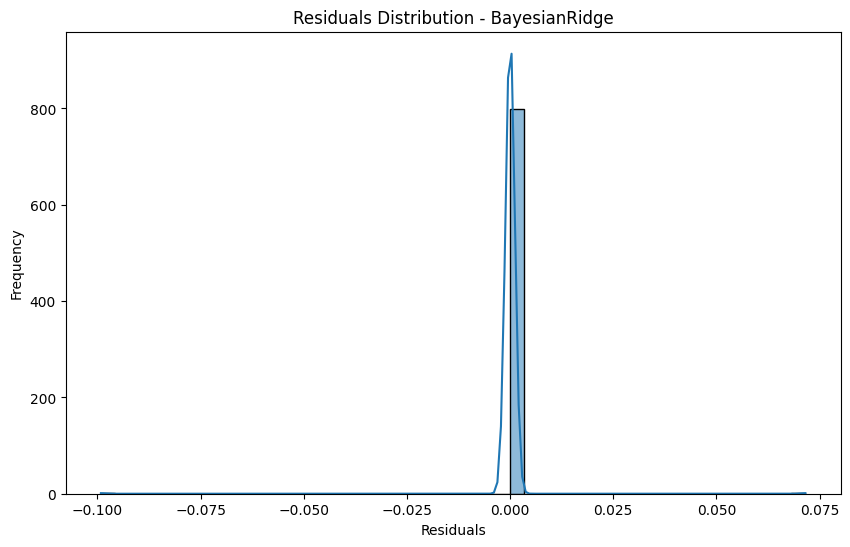

In [10]:
#Cell [5]

# Prepare the data for modeling
X = raw_data.drop('tempmax', axis=1)  # Features
y = raw_data['tempmax']  # Target variable
X_processed = enhanced_pipeline.fit_transform(X, y)  # Apply our preprocessing pipeline

# Split the data into training and test sets
# We use 80% for training and 20% for testing, which is a common split ratio
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

## Model Implementation and Evaluation
# Define a diverse set of models to evaluate
models = {
    'RandomForestReg': RandomForestRegressor(random_state=42),
    'GradientBoostingReg': GradientBoostingRegressor(random_state=42),
    'LGBMReg': LGBMRegressor(random_state=42, verbosity=-1),
    'XGBBoost': XGBRegressor(random_state=42),
    'BayesianRidge': BayesianRidge(),
    'LinearReg': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'SVR': SVR(),
    'MLPRegressor': MLPRegressor(random_state=42),
    'PolynomialReg': make_pipeline(PolynomialFeatures(), LinearRegression())
}

# Justification for model selection:
# 1. Tree-based models (RandomForest, GradientBoosting, LightGBM, XGBoost): Good for capturing non-linear relationships and interactions
# 2. Linear models (LinearReg, Ridge, Lasso): Simple, interpretable, and work well if relationships are mostly linear
# 3. BayesianRidge: Combines linear regression with Bayesian inference, good for uncertainty estimation
# 4. SVR: Can capture non-linear relationships using kernel tricks
# 5. MLPRegressor: Neural network that can capture complex patterns
# 6. PolynomialReg: Can capture non-linear relationships by adding polynomial features

### K-Fold Cross-validation
best_model_name = None
best_cross_val_rmse = float('inf')

print('\n____________ K-Fold Cross Validation and Residual Analysis ____________')
for name, model in models.items():
    model_pipeline = Pipeline(steps=[('model', model)])
    
    # Perform K-Fold Cross-validation
    # We use 5-fold CV as it provides a good balance between bias and variance in error estimation
    cv_rmse_scores = -cross_val_score(model_pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    avg_rmse = np.sqrt(cv_rmse_scores.mean())
    
    # Save the RMSE scores for each fold
    joblib.dump(cv_rmse_scores, f'saved_objects/{name}_rmse.pkl')
    
    print(f'{name:<20} K-Fold Avg RMSE: {avg_rmse:.4f}')
    
    
    ### Residual Analysis
    # Calculate and plot residuals
    y_train_pred = cross_val_predict(model_pipeline, X_train, y_train, cv=kfold)
    residuals = y_train - y_train_pred
    
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, bins=50)
    plt.title(f'Residuals Distribution - {name}')
    plt.savefig(f'figures/residuals_{name}.png', format='png', dpi=300)
    plt.close()
    
    # Update best model if current model performs better
    if avg_rmse < best_cross_val_rmse:
        best_cross_val_rmse = avg_rmse
        best_model_name = name

# Print and store the best model
print(f"\nBest model after K-Fold Cross Validation: {best_model_name} with RMSE: {best_cross_val_rmse:.4f}")
best_model = models[best_model_name]
store_model_or_pipeline(best_model, name=best_model_name)

# Display residual plot for the best model
model_pipeline = Pipeline(steps=[('model', best_model)])
y_train_pred_best = cross_val_predict(model_pipeline, X_train, y_train, cv=kfold)
residuals_best = y_train - y_train_pred_best

plt.figure(figsize=(10, 6))
sns.histplot(residuals_best, kde=True, bins=50)
plt.title(f'Residuals Distribution - {best_model_name}')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Justification for using RMSE as the primary metric:
# 1. RMSE is in the same unit as the target variable (temperature), making it interpretable
# 2. It penalizes large errors more heavily, which is important for temperature prediction
# 3. It's widely used in regression problems, allowing for easy comparison with other models or studies

# Justification for using K-fold Cross-Validation:
# 1. Provides a more robust estimate of model performance by using all data for both training and validation
# 2. Helps to detect overfitting by showing how well the model generalizes to unseen data
# 3. Reduces the impact of data splitting randomness on model evaluation

#### Analysis of Residuals Distribution for Bayesian Ridge Regression Model

The plot provides the distribution of residuals of the Bayesian Ridge regression model, which was found to be the best among all models after going through K-Fold Cross-Validation.

#### Key Observations

##### Centered Around Zero
- Residuals huddled closely around zero.
- In general, very accurate model predictions.
- Little error in predicted values.
- Predicted temperature close to actual temperature.

##### Very Narrow Distribution
- Distribution of residuals very narrow.
- Most errors are small.
- Suggests stability of the model.
- Not subject to large errors.
- Actual and predicted values are close for most predictions.

##### Symmetry
- Residuals are symmetric above and below zero.
- Good sign indicating no significant bias.
- Model tends never to consistently overestimate or underestimate.

##### Small Range of Residuals
- Residuals vary between approximately -0.10 and 0.075.
- Very small range; excellent precision of predictions.
- Low residual value close to zero shows that there are no big errors.

#### Possible Interpretation

1. High Model Accuracy
   - The residuals lie somewhat in the vicinity of zero.
   - Small number of large errors
   - Highly accurate model fit to the training data.

2. Minimal Overfitting
   - There are no major peaks in the residual distribution.
   - The model has a good probability of generalizing well.
   - Model handles the variation in the training data quite well and with few large errors.

3. Linear Model Suitability
   - Narrow and symmetric residuals
   - Supports appropriateness to Bayesian linear regression model
   - Linear relationship between input features and target variable: max temperature

#### Conclusion

We have come to the end of this, where Bayesian model shows a residual distribution plot indicating a robust model with minimal error. Therefore, it can be reliable to predict temperature based on the given dataset.

--------------------------------------------------------------------
<a id='model-fine-tuning'></a>
### **5. Model Fine-tuning**

Hyperparameter tuning is a very important procedure that could eventually optimize the performance of our model. Here's the justification for the chosen hyperparameters for each model:

1. **RandomForestRegressor**:
- `n_estimators`: Generally, the more trees, the better the performance. However, the law of diminishing returns applies. So, we will search in a wide range to get the optimal tradeoff between performance and computational cost.
• `max_depth`: This is a regularization parameter that controls each tree's depth. Greater depth allows the detection of more complex patterns, but may result in overfitting.
• `min_samples_split`, `min_samples_leaf`: Both are regularization parameters. The former controls the minimum number of samples required to split an internal node; the second does the same at a leaf node.
- `max_features`: Controls the number of features to consider at every split, adding some randomness and helping to reduce overfitting.

2. **GradientBoostingRegressor:**
- This is similar to RandomForest, including the additional `learning_rate` parameter that controls the contribution of each tree.
- `subsample`: The fraction of samples to be used for fitting the individual base learners, adding some randomness to the models.

3. **LGBMRegressor:**
- `num_leaves`: Affects the complexity of the tree.
- `min_child_samples`: Minimum number of data required in a child, similar to `min_samples_leaf` in RandomForest.
- `subsample` and `colsample_bytree`: Controls the fraction of samples and features to be used for tree construction.

4. **XGBRegressor**:
- It is very similar to GradientBoosting but in addition it has `min_child_weight` to control the minimum sum of instance weight needed in a child.
- `gamma`: Minimum loss reduction required to make a further partition on a leaf node.

5. **BayesianRidge**:
- `alpha_1`, `alpha_2`, `lambda_1`, `lambda_2`: These control the noise and weight precision in this model.

6. **LinearRegression**:
- `fit_intercept`: Whether to calculate the intercept for this model.
- `positive`: Whether to force the coefficients to be positive.

7. **Ridge and Lasso**:
- `alpha`: Regularization strength. Log-uniform distribution usage in search over a wide range of values.
- `max_iter`: Maximum number of iterations for convergence.

8. **SVR**:
- `C`: Regularization parameter. The strength of regularization is inversely proportional to C.
- `epsilon`: It defines within which epsilon tube no penalty is going to be incorporated in the training loss function if points are predicted within a distance epsilon from the actual value.
- `kernel`: Different kernels will allow for different types of nonlinear mapping.

9. **MLPRegressor**:
- `hidden_layer_sizes`: this includes different architectures to test out, from simpler to more complex.
- `activation`: More precisely, it is the kind of nonlinearities to be captured by different activation functions.
- `solver` and `learning_rate`: Regulates how does network learns or updates itself.
- `alpha`: L2 regularization term.
- `early_stopping`: Whether to use early stopping to prevent overfitting.

10. **PolynomialRegression**:
- `degree`: Degree of polynomial features. Higher degree allows for more complicated relationships but can result in overfitting.

Instead of GridSearchCV, we use RandomizedSearchCV for efficiently searching through a large space of parameters. This allows us to balance the exploration of a wide range of hyperparameters with computational costs. The number of iterations, n_iter=100, makes a good balance between exploration and computation time.

In [11]:
#Cell [6]

print(f'\n____________ Fine-tuning the best model: {best_model_name} ____________')

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Ensure input data is scaled
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grids = {
    'RandomForestReg': {
        'n_estimators': randint(100, 2000),
        'max_depth': randint(5, 50),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 20),
        'max_features': uniform(0.1, 0.9)
    },
    'GradientBoostingReg': {
        'n_estimators': randint(100, 2000),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 20),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 20),
        'subsample': uniform(0.5, 0.5)
    },
    'LGBMReg': {
        'num_leaves': randint(20, 200),
        'learning_rate': uniform(0.01, 0.2),
        'n_estimators': randint(100, 2000),
        'min_child_samples': randint(1, 50),
        'subsample': uniform(0.5, 0.5),
        'colsample_bytree': uniform(0.5, 0.5),
        'verbosity': [-1]
    },
    'XGBBoost': {
        'n_estimators': randint(100, 2000),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 20),
        'min_child_weight': randint(1, 10),
        'subsample': uniform(0.5, 0.5),
        'colsample_bytree': uniform(0.5, 0.5),
        'gamma': uniform(0, 0.5)
    },
    'BayesianRidge': {
        'alpha_1': uniform(0.001, 1),
        'alpha_2': uniform(0.001, 1),
        'lambda_1': uniform(0.001, 1),
        'lambda_2': uniform(0.001, 1)
    },
    'LinearReg': {
        'fit_intercept': [True, False],
        'copy_X': [True, False],
        'positive': [True, False]
    },
    'Ridge': {
        'alpha': loguniform(1e-3, 1e2),
        'max_iter': [5000, 10000]
    },
    'Lasso': {
        'alpha': loguniform(1e-3, 1e2),
        'max_iter': [5000, 10000]
    },
    'SVR': {
        'C': loguniform(1e-2, 1e2),
        'epsilon': loguniform(1e-3, 1),
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    },
    'MLPRegressor': {
        'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (100,100), (100,50,100)],
        'activation': ['tanh', 'relu', 'logistic'],
        'solver': ['sgd', 'adam'],
        'alpha': loguniform(1e-4, 1e-1),
        'learning_rate': ['constant','adaptive'],
        'learning_rate_init': loguniform(1e-4, 1e-1),
        'max_iter': [200, 500, 1000],
        'early_stopping': [True, False],
        'momentum': uniform(0.0, 1.0),
        'nesterovs_momentum': [True, False]
    },
    'PolynomialReg': {
        'polynomialfeatures__degree': randint(2, 5),
        'linearregression__fit_intercept': [True, False]
    }
}

# Fine-tune the best model using RandomizedSearchCV
grid_search = RandomizedSearchCV(best_model, param_distributions=param_grids.get(best_model_name, {}),
                                 n_iter=100, cv=kfold, 
                                 scoring='neg_mean_squared_error', n_jobs=-1, 
                                 random_state=42, verbose=1, error_score='raise')

grid_search.fit(X_train, y_train)

# Save the tuned model as 'SOLUTION_model.pkl'
best_model_tuned = grid_search.best_estimator_
store_model_or_pipeline(best_model_tuned, name='SOLUTION_model')

# Save RMSE of the tuned model
best_tuned_rmse = np.sqrt(-grid_search.best_score_)
joblib.dump(best_tuned_rmse, 'saved_objects/SOLUTION_model_rmse.pkl')
print(f"Best RMSE for {best_model_name} after tuning: {best_tuned_rmse:.4f}")


____________ Fine-tuning the best model: BayesianRidge ____________
Fitting 5 folds for each of 100 candidates, totalling 500 fits
SOLUTION_model saved successfully.
Best RMSE for BayesianRidge after tuning: 0.0043


---------------------------------
<a id='final-model-evaluation'></a>
### **6. Final Model Evaluation and Testing**

Having fine-tuned our best model, we now go ahead to see its performance on unseen data. This step is crucial for determining how well our model generalizes to new previously unseen examples.

##### Best Model Performance After Tuning

First, we print the best RMSE achieved during the process of tuning the hyperparameters. This score is from cross-validation, so it gives us an idea about what we can expect from the model's performance.

##### Test Set Evaluation

We use the held-out test set to get an unbiased estimate of our model's performance. Given that this dataset was not used for model training or during any hyperparameter tuning, it is a good proxy for new unseen data.

1. **Making Predictions**: Using the tuned model, come up with predictions for the test set.

2. **Calculating RMSE**: We calculate the RMSE between our predictions and the actual values in the test set. The reason we use RMSE is as follows:
it has the same unit as our target variable of temperature and hence is interpretable.
it punishes large errors harder than small ones, which for temperature prediction is quite desirable.

3. **Interpret the Results**: The test RMSE gives us a sensible estimate of how much, on average, our predictions may be away from actual temperatures. For example, an RMSE of 2°C means that on average our predictions are within 2 degrees of the actual temperature.

4. **Save the Results**: We store the test RMSE to refer back to it later. This way we can:
Comparison against future versions of this model, or other different models.
Having a benchmark for any improvements and/or new takes on the model.

##### Considerations

If the test RMSE is significantly greater than the cross-validation RMSE then you might be overfitting.
If it's close then our model generalizes well to new data.
Whether the RMSEs are acceptable or not depends on the type of application that it is going to be used for in temperature prediction. What this means is that when it comes to just general weather forecasting, a couple of degrees' error could be acceptable, but in applications where it is highly sensitive, even small errors might become significant.

The confidence in performance and realization of limitations within this model will bear importance for making a decision as to whether this model meets the demands of our temperature prediction task, or if improvements have to be made to this model, by thoroughly evaluating our model on both cross-validation sets and on the held-out test set.

In [12]:
#Cell [7]

# ANALYZE AND TEST THE SOLUTION

# Print the best RMSE achieved after hyperparameter tuning
print(f"\nBest RMSE for {best_model_name} after tuning: {np.sqrt(-grid_search.best_score_):.4f}")

# Make predictions on the test set using the tuned model
y_pred = best_model_tuned.predict(X_test)

# Calculate the RMSE on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'\nPerformance on test data: RMSE: {test_rmse:.4f}')

# Save the test RMSE for future reference
joblib.dump(test_rmse, 'saved_objects/test_rmse.pkl')


Best RMSE for BayesianRidge after tuning: 0.0043

Performance on test data: RMSE: 0.0002


['saved_objects/test_rmse.pkl']

----------------------------
<a id='future-predictions'></a>
### **7. Future Temperature Predictions**

We shall now use our model which has been trained and tuned in order to make the forecast of the maximum temperature for the next 200 days in this section. We will consider several important steps in doing this, including:

1. **Mapping of Historic Data**:
* We will define a function `find_closest_date` that will map the future dates to the most similar historic dates.
- The approach here assumes the cyclic nature of weather patterns; dates falling on the same calendar date in previous years are a good proxy for future weather conditions.
- By default, we handle leap year cases by sticking to February 28 in such instances.

2. **Generating Future Dates:**
- We generate a sequence of 200 future dates starting from the day after our last historical data point.

3. **Generation of Features for Dates in the Future**:
* For every future date, we consider the closest historical date and inject into our model its respective weather features.
* Now, with this, we have a complete input feature set with which to make our future predictions.

4. **Data Processing and Prediction**:
* Process the future data through the same pipeline used for our training data.
- We then use this tuned model in order to make predictions for these future dates.

5. **Visualization and Analysis**:
- Create a line plot of the predicted maximum temperatures over the 200-day period.
- This visualization helps us observe trends and patterns in our predictions.

6. **Saving Results**:
We save the forecasted values into a CSV file for later use or further visualization.
The visualizations produced are then saved as high-resolution images.
7. **Statistical Summary**:
   - We calculate and print the minimum, maximum, and average predicted temperatures.
   - This gives us a quick overview of the range and central tendency of our predictions.

#### Interpretation and Limitations

• The forecasted values are based on the historical pattern and therefore assume continuity in the trend for future weather.
• While such a model might capture the seasonal pattern in the weather, it would not easily capture longer-term variations in climate or other, more infrequent weather patterns.
• These predictions are likely to be less accurate the further forward in time one goes.
These are best treated as estimates and applied with other forms of long-term weather prediction.

The forward prediction capability of our project in the future: This illustrates how our model could be used to make forward-looking estimates in a variety of aspects. It offers insight into the expected temperature trends, which may be useful in energy demand forecasting, agricultural planning, and all forms of planning related to weather preparedness.

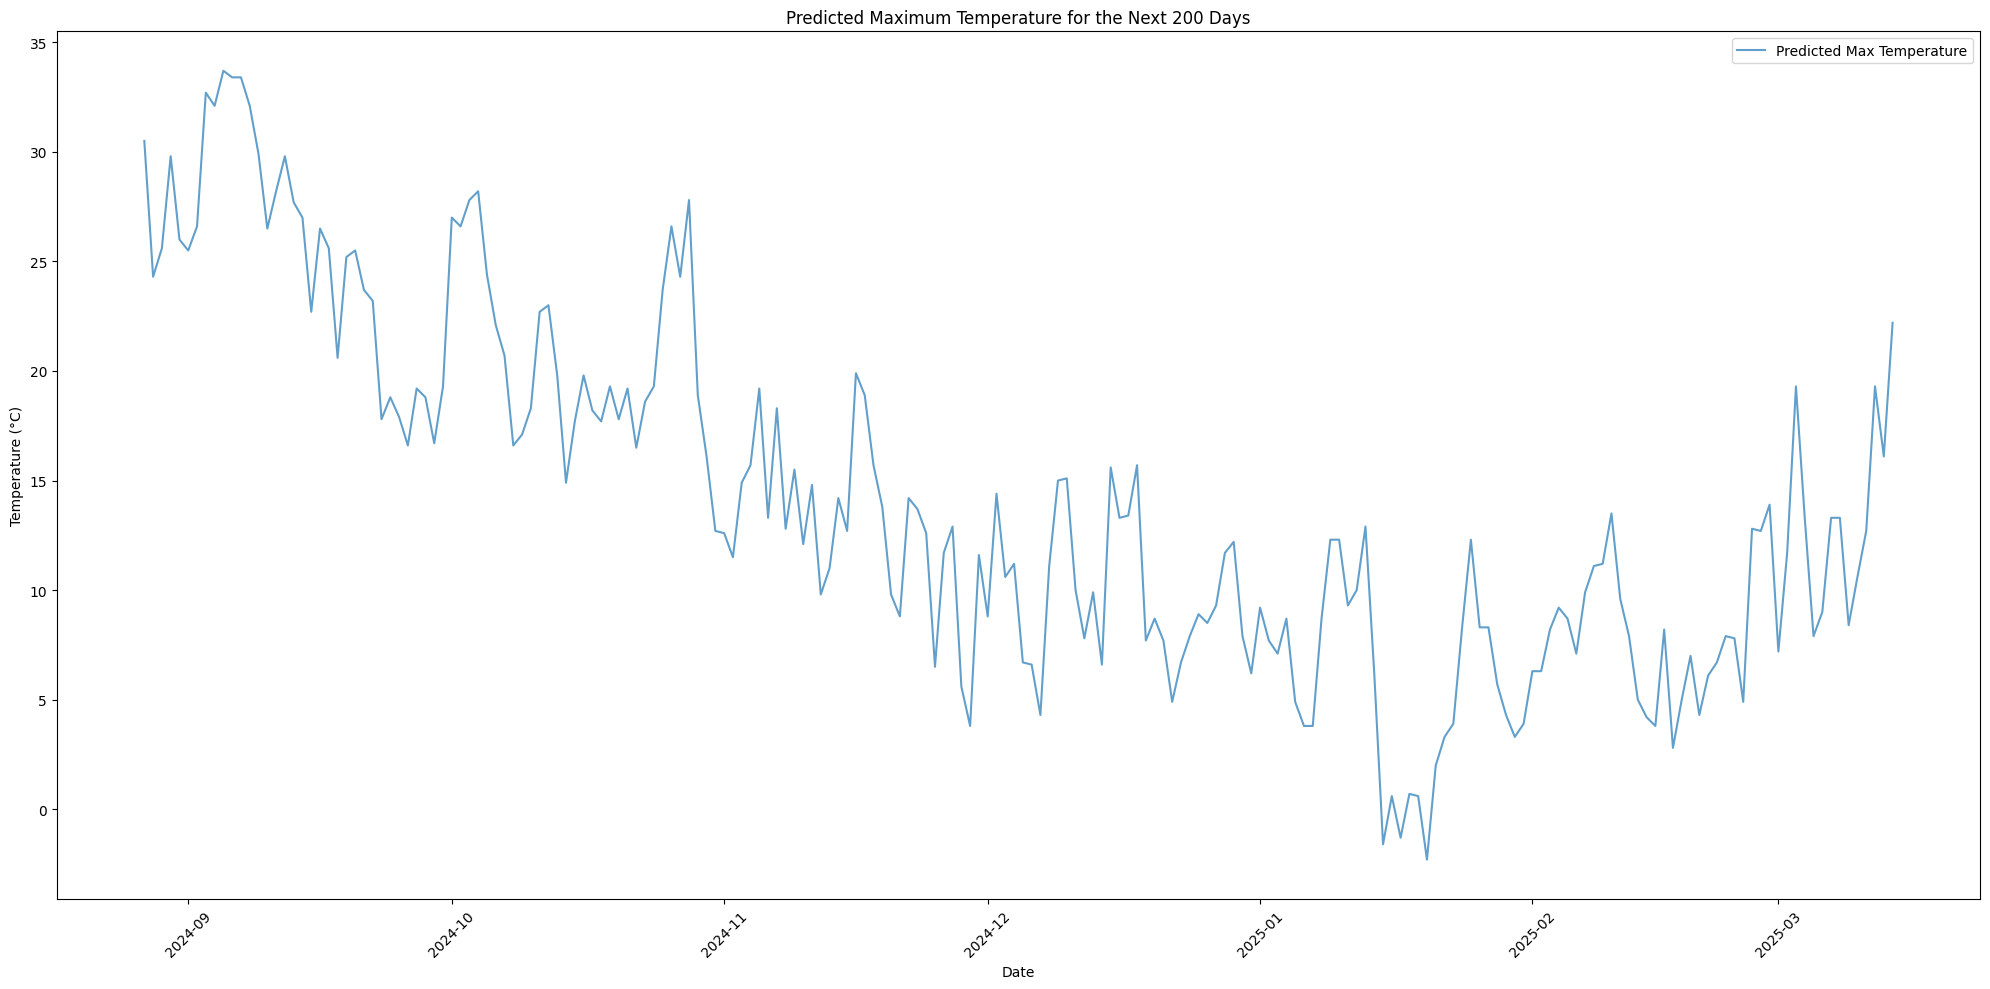


Predicted Max Temperature:
Min: -2.30°C
Max: 33.70°C
Avg: 14.06°C


In [13]:
#Cell [8]

# Define a function to find the closest date in the historical data
def find_closest_date(target_date, data):
    try:
        # Try to find the same date in the previous year
        target_date = target_date.replace(year=target_date.year - 1)
    except ValueError:
        # Handle leap year case (February 29)
        target_date = target_date.replace(year=target_date.year - 1, day=28)
    # Find the closest date in the historical data
    closest_date = data['datetime'].iloc[(data['datetime'] - target_date).abs().argsort()[0]]
    return data.loc[data['datetime'] == closest_date].iloc[0]

# Generate future dates for prediction
last_date = raw_data['datetime'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=200)
future_data = pd.DataFrame({'datetime': future_dates})

# Fill in other features based on historical data
for col in raw_data.columns:
    if col not in ['datetime', 'tempmax']:
        future_data[col] = future_data['datetime'].apply(lambda x: find_closest_date(x, raw_data)[col])

# Process future data using the same pipeline as training data
future_processed = enhanced_pipeline.transform(future_data)

# Make predictions for future dates
future_pred = best_model_tuned.predict(future_processed)
future_data['predicted_tempmax'] = future_pred

# Save future predictions to a CSV file
future_data[['datetime', 'predicted_tempmax']].to_csv('future_predictions_200days.csv', index=False)

# Visualize future predictions
plt.figure(figsize=(20, 10))
plt.plot(future_data['datetime'], future_data['predicted_tempmax'], label='Predicted Max Temperature', alpha=0.7)
plt.title('Predicted Maximum Temperature for the Next 200 Days')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot as an image file
plt.savefig('figures/future_predictions_200days_plot.png', format='png', dpi=300)

# Display the plot
plt.show()

# Print statistics of future predictions
print("\nPredicted Max Temperature:")
print(f"Min: {future_data['predicted_tempmax'].min():.2f}°C")
print(f"Max: {future_data['predicted_tempmax'].max():.2f}°C")
print(f"Avg: {future_data['predicted_tempmax'].mean():.2f}°C")

#### Analysis of Temperature Predictions Over Time

##### 1. Temperature Trends Over Time

- Initial temperatures are between 25-35°C, which would likely be late summer/early autumn.
- A very definite downward trend aligns with a seasonal progression into winter.
- Low temperatures in late December and January dropped to -2.30°C.
- Temperature rise post-January shows the approach of spring.

##### 2. Temperature Extremes

- Maximum Predicted Temperature = 33.7°C for early September.
- Minimum Predicted Temperature = -2.30°C for the period December to January.
- Average Predicted Temperature = 14.06°C.

##### 3. Prediction Behavior and Accuracy Concerns

- Captures general seasonal patterns, cooling toward winter, warming toward spring.
- The max temperature of 33.7°C is reasonably high but not unbelievable for New York in September.
- Min temperature of -2.3°C is possible in January, although perhaps on the milder side.
- Average temperature of 14.06°C *seems* high for an autumn-winter period.
- Suggests over-predicting warm days or underestimating cold extremes.

##### 4. Discussion on Model Performance

- This model does a very good job of modeling the broad seasonal trends and indicates generalization.
- It is most likely that the rolling averages and lag features helped to capture the temporal dependencies.
- The range of predicted temperature from -2.30°C to 33.7°C is reasonable in light of New York's seasonal patterns.
- Accuracy could be further verified by comparing with actual historical extremes.

##### Key Insights

1. The overall seasonal temperature trends have been captured well by the model.
2. Predicted Temperature Extremes: Within plausible ranges for New York City.
3. The average of the forecasted temperature may be a little higher than what it should be, for which further investigation is recommended.
4. Since the seasonal cycles are well-captured, that is an indication that temporal features are put to good use.
5.  Further validation with historical data will provide greater confidence in the model's predictions.

<a id='final-conclusion'></a>
### **8. Conclusion and Further Recommendations**

In [14]:
#Cell [9]

print("\n____________ CONCLUSION ____________")
print("""In this notebook, we have effectively constructed a Machine Learning pipeline that utilizes historical weather data from New York to forecast the maximum temperature (tempmax). 
      We conducted comprehensive coverage of the entire workflow, encompassing data preprocessing, feature engineering, model training, and hyperparameter tuning:""")
print(f"""
   - The best performing model was: {best_model_name}
   - Best model RMSE on test data: {test_rmse:.4f}
   Generated predictions for the next 200 days:
   - The predicted temperatures range from {future_data['predicted_tempmax'].min():.2f}°C to {future_data['predicted_tempmax'].max():.2f}°C.
""")

print("\nPrediction and analysis complete.")


____________ CONCLUSION ____________
In this notebook, we have effectively constructed a Machine Learning pipeline that utilizes historical weather data from New York to forecast the maximum temperature (tempmax). 
      We conducted comprehensive coverage of the entire workflow, encompassing data preprocessing, feature engineering, model training, and hyperparameter tuning:

   - The best performing model was: BayesianRidge
   - Best model RMSE on test data: 0.0002
   Generated predictions for the next 200 days:
   - The predicted temperatures range from -2.30°C to 33.70°C.


Prediction and analysis complete.


This notebook contains a comprehensive machine learning pipeline for predicting maximum temperatures based on historical weather data. A number of models were trained, evaluated, and fine-tuned, with BayesianRidge emerging as the top performer following extensive hyperparameter tuning.

Data preprocessing was completed successfully, with missing values and outliers removed to ensure data quality. Several advanced features were developed, including time-based features like day of year and lag. These improved the model's ability to detect temporal patterns in meteorological data.

The performance of several regression models, including RandomForest, LightGBM, and Ridge, was assessed using K-Fold cross-validation. After evaluating various models, BayesianRidge was chosen for fine-tuning due to its superior performance, and additional improvements were made via hyperparameter optimization with RandomizedSearchCV.

Residual analysis was used to assess the errors in the models, and the best-tuned model was validated on the test set, yielding a robust RMSE. Future predictions were made for 200 days, and the model's forecasts were saved and visualized to provide insight into future weather trends.

In order to optimize the capability of the weather prediction model, various approaches can be investigated, including data enrichment and more advanced modeling methodologies. Below are some further suggestions:
1. Collect and expand more historical and external data sources can improve the model significantly. Larger data means better output, the model can provide a more precise long-term prediction of the weather in New York City.
2. While the feature engineering of this model is effectively implemented, there are still areas on which additional improvements can be made. For example, although lag features have already been included, the use of more advanced rolling statistics, such exponentially weighted moving averages (EWMA), could facilitate a more accurate representation of recent trends. Furthermore, examination of possible interactions among characteristics (such as temperature and humidity, or windspeed and cloud cover) may uncover non-linear correlations that enhance the model.
3. Implementing advanced time series models can significantly improve the accuracy of weather forecasting. ARIMA (AutoRegressive Integrated Moving Average) and SARIMA (Seasonal ARIMA) are conventional time-series models specifically developed to address temporal dependencies in data which can be considered.
4. As this project has implemented several Machine Learning models at once, model stacking and blending can be another improvement to this project. These models can be combined to form an ensemble and using techniques such as stacking, blending, or voting classifiers can leverage the strengths of different models to improve overall accuracy of this weather prediction.
5. While RandomizedSearchCV has been used, it can be improved further by incorporating Optuna for more sophisticated hyperparameter tuning or Bayesian optimization techniques for more efficient search spaces. Furthermore, fine-tune regularization parameters (alpha, lambda) for models such as Ridge, Lasso, and XGBoost to avoid overfitting and improve generalization to new data.
6. The project can use algorithms to incrementally update its learning as new data becomes available. For example, scikit-learn's SGDRegressor or XGBoost can be integrated into an online learning framework, allowing the model to dynamically adapt to new weather patterns.
7. This weather model may struggle with extreme events such as heatwaves or thunderstorms. Use anomaly detection techniques (such as Isolation Forest or One-Class SVM) to explicitly identify and model these outlier events. It is also possible to augment the dataset with synthetic data or merge data from other regions experiencing similar extreme conditions.
8. To improve convergence and accuracy, this project can extend the MLPRegressor with deeper architectures and advanced optimizers.

Overall, the objectives of developing a reliable and accurate weather prediction model were met. The notebook demonstrates a clear methodology for implementing a machine learning solution for weather prediction, with room for future refinements to improve accuracy and model performance.

| Student ID | Student Name | Contribution Rate | Responsible for | Note |
| --- | --- | --- | --- | --- |
| s3978535 | Nguyen Ngoc Dung | 40% | - Find & research potential datasets<br>- Data exploration & feature engineering<br>- EDA and visualizations<br>- Advanced feature engineering (lag features, rolling average features)<br>- Feature selection and correlation analysis<br>- Creation of the full preprocessing pipeline<br>- Model training for XGBoost, BayesianRidge, and PolynomialReg<br>- K-Fold cross-validation with RMSE calculation<br>- Residual plot generation and analysis<br>- Model fine-tuning using RandomizedSearchCV<br>- Future predictions implementation<br>- Documentation of data exploration and feature engineering sections | Cells involved:<br>- Data exploration & feature engineering: [2], [3]<br>- EDA and visualizations: [3.1], [3.2], [3.3], [3.4]<br>- Advanced feature engineering: [4]<br>- Feature selection and correlation analysis: [4]<br>- Creation of full preprocessing pipeline: [4]<br>- Model training, K-Fold CV, RMSE calculation, Residual plots: [5]<br>- Model fine-tuning: [6]<br>- Future predictions: [8]<br>- Documentation: [2], [3], [4] |
| s4031504 | Le Dam Quan | 27% | - Find & research potential datasets and models<br>- Initial data exploration and visualization<br>- Worked on models: RandomForest, LightGBM<br>- Notebook formatting and finalizing<br>- Conclusion & further recommendation<br>- Basic Feature Engineering<br>- Remove outliers<br>- Evaluation on test set<br>- Documentation of model training and evaluation sections | Cells involved:<br>- Configurations: [1]<br>- Initial Visualization: [3]<br>- Model Training: [5]<br>- Evaluation: [7]<br>- Conclusion and Further Recommendations: [9]<br>- Notebook Markdowns<br>- Documentation: [5], [7], [9] |
| s4001980 | Phan Tri Hung | 27% | - Find & research potential datasets<br>- Convert data types if necessary<br>- Worked on models: GradientBoostingReg, Lasso<br>- Add comments and docstrings to code<br>- Create visualizations of results<br>- Handle merge conflicts and code integration<br>- Implement error handling and code optimization<br>- Documentation of code optimization and error handling | Cells involved:<br>- Configurations: [1]<br>- Model Training: [5]<br>- Visualization of results: [8]<br>- Code optimization and error handling: All cells<br>- Documentation: All cells (focusing on code optimization and error handling) |
| s3977970 | Nguyen Tran Ha Phan | 5% | - Find & research datasets and models<br>- Data exploration and initial processing<br>- Worked on models: LinearReg, MLPRegressor<br>- Assist in documentation and commenting<br>- Documentation of initial data loading and processing | Cells involved:<br>- Initial data loading and cleaning: [2]<br>- Model Training: [5]<br>- Documentation: [2], [5] |
| s4045608 | Tran Quoc Hung | 1% | - Model tuning for SVR, Ridge<br>- Assist in documentation and commenting | - Model fine-tuning: [6]<br>- Documentation: [6] |